In [1]:
# Core Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Model (Using XGBoost as it performed well in the original project summary)
import xgboost as xgb

# Widgets for interactive session
import ipywidgets as widgets
from ipywidgets import interact, fixed, VBox, HBox, HTML, Layout, Button, Output
from IPython.display import display, clear_output
import datetime # For date picker

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')



In [1]:
df = pd.read_csv('cleaned_data.csv')

# --- Initial Inspection ---
print("\n--- Dataset Head ---")
display(df.head())

print("\n--- Dataset Info ---")
df.info()

print("\n--- Dataset Statistical Summary ---")
display(df.describe(include='all'))

print("\n--- Missing Values per Column ---")
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
if not missing_values.empty:
    print(missing_values)
else:
    print("No missing values found.")

print(f"\nDataset shape: {df.shape}")

NameError: name 'pd' is not defined

In [17]:
# --- Target Variable ---
TARGET_COLUMN = 'nitrate_groundwater_mg_L'

# Ensure target variable is numeric and handle missing values by dropping rows
if TARGET_COLUMN in df.columns:
    df[TARGET_COLUMN] = pd.to_numeric(df[TARGET_COLUMN], errors='coerce')
    initial_rows = len(df)
    df.dropna(subset=[TARGET_COLUMN], inplace=True)
    print(f"Dropped {initial_rows - len(df)} rows with missing target variable ('{TARGET_COLUMN}').")
else:
    print(f"❌ Error: Target column '{TARGET_COLUMN}' not found in the dataset.")
    # Consider stopping execution if target is missing

# List of columns to remove from both numerical and categorical features
columns_to_remove = [
    'well_no', 'original_wellno', 'well_code', 'well_objectcode', 'network_name', 'filter_no',
    'x_coord', 'y_coord', 'province', 'local_placename', 'ground_surface_elevation',
    'depth_topfilter', 'depth_bottomfilter', 'height_wellcasing', 'diam_wellcasing',
    'well_installationyear', 'aquitard_code', 'tritium_code', 'sample_year', 'plan_year',
    'sample_day', 'sample_month', 'O2_5_field', 'T_5_field', 'EC_5_field', 'H_5_field',
    'SH_field', 'HCO3_detect_field', 'HCO3_field', 'Land_use_type'
]

# Initialize active_numerical_cols and active_categorical_cols if not already defined
active_numerical_cols = numerical_cols.copy()
active_categorical_cols = categorical_cols.copy()

# Remove these columns from the feature lists
active_numerical_cols = [col for col in active_numerical_cols if col not in columns_to_remove]
active_categorical_cols = [col for col in active_categorical_cols if col not in columns_to_remove]

# Recreate the model_feature_columns list after removal
model_feature_columns = active_numerical_cols + active_categorical_cols

# Drop these columns from the dataframe before training
df = df.drop(columns=[col for col in columns_to_remove if col in df.columns], errors='ignore')

# Identify numerical and categorical columns from the remaining df_features
# Exclude target column from features list
numerical_cols = df_features.select_dtypes(include=np.number).columns.tolist()
if TARGET_COLUMN in numerical_cols:
    numerical_cols.remove(TARGET_COLUMN)

categorical_cols = df_features.select_dtypes(include=['object', 'category']).columns.tolist()

# Re-assign df to df_features for further processing (or select columns for df)
df = df_features.copy() # Working with the feature set + target

# Ensure no overlap between numerical and categorical lists after adjustments
numerical_cols = list(set(numerical_cols) - set(categorical_cols))
categorical_cols = list(set(categorical_cols) - set(numerical_cols))

# Final check on feature lists
numerical_cols = [col for col in numerical_cols if col in df.columns and col != TARGET_COLUMN]
categorical_cols = [col for col in categorical_cols if col in df.columns and col != TARGET_COLUMN]

print(f"\nFinal Numerical Features ({len(numerical_cols)}): {numerical_cols}")
print(f"Final Categorical Features ({len(categorical_cols)}): {categorical_cols}")

# Display data types again after potential conversions
print("\n--- Dataset Info After Preliminary Cleaning ---")
df.info()

Dropped 0 rows with missing target variable ('nitrate_groundwater_mg_L').

Final Numerical Features (53): ['HCO3_field', 'potassium', 'nh4n', 'Livestock_density_LSU_per_ha', 'chromium', 'sodium', 'livestock_density_LU_ha', 'well_installationyear', 'barium', 'evaporation_mm', 'fertilizer_kg_ha', 'manure_kg_ha', 'copper', 'EC_5_field', 'ground_surface_elevation', 'ptopp', 'drought_days', 'T_5_field', 'Rel_humidity_percent', 'x_coord', 'groundwater_level_cm', 'ec_lab', 'iron', 'manganese', 'y_coord', 'Precipitation_mm', 'stronium', 'precipitation_mm', 'O2_5_field', 'height_wellcasing', 'calcium', 'chloride', 'cadmium', 'diam_wellcasing', 'magnesium', 'nitrate_input_mg_L', 'plan_year', 'arsenic', 'corg', 'no3n', 'permeability_m_day', 'SH_field', 'zinc', 'fluoride', 'ph_lab', 'po4p', 'Sunlight_hours', 'nickel', 'H_5_field', 'Avg_temperature_C', 'aluminium', 'lead', 'so4']
Final Categorical Features (3): ['aquitard_code', 'HCO3_detect_field', 'tritium_code']

--- Dataset Info After Prelimina

In [ ]:
# --- Define Features (X) and Target (y) ---
# Using all identified numerical and categorical columns as features for this example.
# In a real scenario, feature selection/engineering would be more refined.
X = df[numerical_cols + categorical_cols]
y = df[TARGET_COLUMN]

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
if X.empty:
    print("❌ Error: Feature set X is empty. Check feature identification and cleaning steps.")
else:
    display(X.head())

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape (X_train, y_train):", X_train.shape, y_train.shape)
print("Test set shape (X_test, y_test):", X_test.shape, y_test.shape)

Features (X) shape: (27101, 56)
Target (y) shape: (27101,)


,HCO3_field,potassium,nh4n,Livestock_density_LSU_per_ha,chromium,sodium,livestock_density_LU_ha,well_installationyear,barium,evaporation_mm,fertilizer_kg_ha,manure_kg_ha,copper,EC_5_field,ground_surface_elevation,ptopp,drought_days,T_5_field,Rel_humidity_percent,x_coord,groundwater_level_cm,ec_lab,iron,manganese,y_coord,Precipitation_mm,stronium,precipitation_mm,O2_5_field,height_wellcasing,calcium,chloride,cadmium,diam_wellcasing,magnesium,nitrate_input_mg_L,plan_year,arsenic,corg,no3n,permeability_m_day,SH_field,zinc,fluoride,ph_lab,po4p,Sunlight_hours,nickel,H_5_field,Avg_temperature_C,aluminium,lead,so4,aquitard_code,HCO3_detect_field,tritium_code
0,255.345,1.00,0.23,3.5,0.9,9.0,2.183421,1978.0,42.641,20.0,173.857475,134.226232,0.62,59.3,8.31685,0.01,16.0,10.2,88,211635.0,104.511077,0.00,2.51,0.38309,467710.0,80,295.405,80.0,0.14,0.55,79.0,16.0,0.045,5.7,6.00,49.967142,1979,0.645,4.9135,0.1,0.832854,-2.22,4.0,0.03,0.00,0.055,70,0.59,7.24,6.5,13.49,0.2,44.0,L9,<,T1
1,255.345,1.00,0.14,3.5,0.9,10.0,2.904139,1978.0,42.641,35.0,136.464441,209.288932,0.62,59.3,8.31685,0.46,12.0,10.2,86,211635.0,159.220367,51.98,2.51,0.38309,467710.0,85,295.405,70.0,0.14,0.55,68.0,21.0,0.045,5.7,8.00,43.617357,1980,0.645,4.9135,0.1,1.024995,-2.22,4.0,0.03,7.40,0.055,120,0.59,7.24,10.5,13.49,0.2,26.0,L9,<,T1
2,255.345,1.00,1.30,3.5,0.9,11.0,1.801470,1978.0,42.641,50.0,182.969100,109.027497,0.62,59.3,8.31685,0.61,8.0,10.2,81,211635.0,124.713875,54.24,2.51,0.38309,467710.0,55,295.405,55.0,0.14,0.55,83.0,28.0,0.045,5.7,8.00,51.476885,1982,0.645,4.9135,0.1,0.573460,-2.22,4.0,0.03,7.40,0.055,220,0.59,7.24,13.0,13.49,0.2,58.0,L9,<,T1
3,255.345,0.60,0.15,3.5,0.9,12.0,2.865434,1978.0,42.641,50.0,166.742981,192.279529,0.62,59.3,8.31685,0.01,8.0,10.2,81,211635.0,57.743021,55.37,2.51,0.38309,467710.0,55,295.405,55.0,0.14,0.55,87.0,36.0,0.045,5.7,7.30,60.230299,1984,0.645,4.9135,0.2,0.229534,-2.22,4.0,0.03,7.38,0.050,220,0.59,7.24,13.0,13.49,0.2,56.0,L9,<,T1
4,255.345,0.47,0.15,3.5,0.9,12.8,2.344822,1978.0,42.641,75.0,119.997286,168.927059,0.62,59.3,8.31685,0.06,5.0,10.2,80,211635.0,81.627843,57.06,2.51,0.38309,467710.0,85,295.405,80.0,0.14,0.55,94.4,40.5,0.045,5.7,7.24,42.658466,1985,0.645,4.0000,0.3,0.527653,-2.22,4.0,0.03,7.38,0.055,300,0.59,7.24,17.9,13.49,0.2,53.2,L9,<,T1



Training set shape (X_train, y_train): (21680, 56) (21680,)
Test set shape (X_test, y_test): (5421, 56) (5421,)


In [19]:
# Create preprocessing pipelines for numerical and categorical features

# Numerical pipeline: Median imputation then StandardScaler
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: Impute missing with "Missing" then OneHotEncoder
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # sparse_output=False for easier inspection if needed
])

# Create ColumnTransformer to apply pipelines to appropriate columns
# Ensure that numerical_cols and categorical_cols are correctly populated and disjoint
# and only contain columns present in X_train

# Filter out columns not present in X_train from numerical_cols and categorical_cols
active_numerical_cols = [col for col in numerical_cols if col in X_train.columns]
active_categorical_cols = [col for col in categorical_cols if col in X_train.columns]


if not active_numerical_cols and not active_categorical_cols:
    print("❌ Error: No active numerical or categorical columns for preprocessing. Check column lists.")
    # Consider stopping execution
elif not active_numerical_cols:
    print("Warning: No numerical features to preprocess.")
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_pipeline, active_categorical_cols)
        ], remainder='passthrough' # Passthrough other columns if any (should be none if lists are exhaustive)
    )
elif not active_categorical_cols:
    print("Warning: No categorical features to preprocess.")
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, active_numerical_cols)
        ], remainder='passthrough'
    )
else:
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, active_numerical_cols),
            ('cat', categorical_pipeline, active_categorical_cols)
        ], remainder='passthrough' # Use 'drop' if you are certain all features are covered
    )


# --- Fit the preprocessor and transform the training data (Example) ---
# This is just to show it works; actual fitting happens in the main model pipeline
try:
    X_train_processed_example = preprocessor.fit_transform(X_train)
    print("\nPreprocessor fitted and training data transformed successfully (example).")
    print("Shape of processed training data (example):", X_train_processed_example.shape)
    # To get feature names after OHE for inspection:
    # try:
    #    feature_names_out = preprocessor.get_feature_names_out()
    #    print("Feature names after preprocessing (first 10):", feature_names_out[:10])
    # except Exception as e:
    #    print(f"Could not get feature names out: {e}")

except Exception as e:
    print(f"❌ Error fitting/transforming with preprocessor: {e}")
    print("Ensure numerical_cols and categorical_cols are correctly defined and present in X_train.")

set_config(display='text') # Reset display to default


Preprocessor fitted and training data transformed successfully (example).
Shape of processed training data (example): (21680, 68)


In [20]:
# --- Define the XGBoost Regressor model ---
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # For regression
    n_estimators=100,             # Number of trees (can be tuned)
    learning_rate=0.1,            # Learning rate (can be tuned)
    max_depth=5,                  # Max depth of a tree (can be tuned)
    subsample=0.8,                # Subsample ratio of the training instance
    colsample_bytree=0.8,         # Subsample ratio of columns when constructing each tree
    random_state=42,
    n_jobs=-1                     # Use all available CPU cores
)

# --- Create the full pipeline: Preprocessor + Model ---
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(
    full_pipeline,       # Your pipeline (includes preprocessing + model)
    param_grid,
    cv=5,                # 5-fold cross-validation
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,           # Use all CPU cores
    verbose=2
)

grid_search.fit(X_train, y_train)

print("✅ Best parameters:", grid_search.best_params_)
print("🏆 Best score (lowest RMSE):", -grid_search.best_score_)


# --- Train the model ---
print("\nTraining the XGBoost model...")
try:
    full_pipeline.fit(X_train, y_train)
    print("✅ Model training completed successfully!")
except Exception as e:
    print(f"❌ Error during model training: {e}")
    print("Check data consistency, feature lists, and preprocessor setup.")



Fitting 5 folds for each of 27 candidates, totalling 135 fits


c:\Users\danib\anaconda3\envs\Nieuweversie\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


✅ Best parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
🏆 Best score (lowest RMSE): nan

Training the XGBoost model...
✅ Model training completed successfully!



--- Model Evaluation on Test Set ---
Mean Absolute Error (MAE): 0.3370
Mean Squared Error (MSE):  4.2449
Root Mean Squared Error (RMSE): 2.0603
R-squared (R²): 0.9662


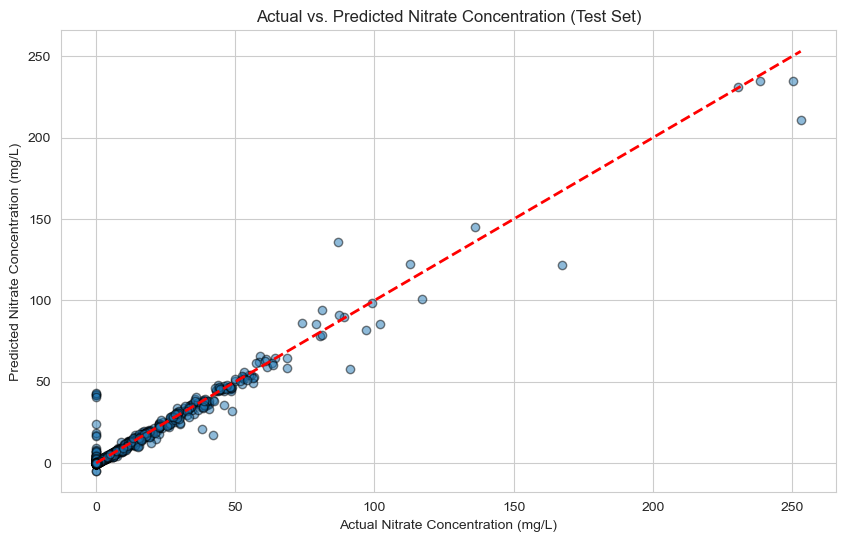

In [37]:
# --- Make predictions on the test set ---
try:
    y_pred_test = full_pipeline.predict(X_test)

    # --- Evaluate the model ---
    mae = mean_absolute_error(y_test, y_pred_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_test)

    print("\n--- Model Evaluation on Test Set ---")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE):  {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    # --- Plotting True vs. Predicted values ---
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolors='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal line
    plt.xlabel("Actual Nitrate Concentration (mg/L)")
    plt.ylabel("Predicted Nitrate Concentration (mg/L)")
    plt.title("Actual vs. Predicted Nitrate Concentration (Test Set)")
    plt.show()

except Exception as e:
    print(f"❌ Error during model evaluation or prediction: {e}")


## Understanding Key Factors Affecting Groundwater Nitrate 🌾💧

This section provides brief explanations of some common variables that can influence nitrate levels in groundwater. Understanding these can help in interpreting results and making informed decisions.

* **`Land_use_type`**: Different land uses (e.g., agriculture, natural, urban) have varying impacts. Agricultural areas, especially with intensive cropping or livestock, can be significant sources of nitrate due to fertilizer and manure application.
* **`fertilizer_kg_ha` (Fertilizer kg/ha)**: The amount of nitrogen fertilizer applied per hectare. Excess fertilizer not taken up by crops can leach into groundwater as nitrate.
* **`manure_kg_ha` (Manure kg/ha)**: Nitrogen from animal manure applied to land. Similar to chemical fertilizers, over-application or improper management can lead to nitrate leaching.
* **`soil_type`**: Soil characteristics influence water infiltration and nutrient retention. Sandy soils, for example, allow water (and dissolved nitrates) to pass through more quickly than clay soils, potentially leading to higher leaching risk.
* **`crop_type`**: Different crops have different nitrogen requirements and uptake efficiencies. Some crops might leave more residual nitrogen in the soil after harvest. Legumes can fix atmospheric nitrogen, potentially contributing to soil nitrogen levels.
* **`aquifer_type`**: Unconfined aquifers are generally more vulnerable to surface contamination than confined aquifers, which are protected by an overlying impermeable layer.
* **`permeability_m_day` (Permeability m/day)**: How easily water can flow through the soil and aquifer material. Higher permeability can mean faster movement of contaminants.
* **`precipitation_mm` (Precipitation)**: Rainfall can influence leaching. Heavy rainfall can wash nitrates from the soil surface into groundwater. Conversely, in dry periods with irrigation, leaching can also occur.
* **`groundwater_level_cm`**: The depth of the water table. Shallower groundwater is often more susceptible to contamination from surface activities.
* **`no3n` (Nitrate-Nitrogen concentration in sample, if available as input)**: If you are providing a recent water test result for nitrate, this is a direct measurement. The model might use this if it's a feature from past data.
* **`sample_year`, `sample_month`**: The time of sampling can be important due to seasonal variations in agricultural practices, rainfall, and temperature, all of which can affect nitrate levels.
* **`depth_topfilter`, `depth_bottomfilter`**: The depth at which the groundwater sample is taken from the well. Deeper samples might be less influenced by recent surface activities compared to shallower ones, depending on local hydrogeology.

**Why are these important?**
Nitrate itself is a crucial nutrient for plant growth, but high concentrations in drinking water can be harmful to human health, particularly for infants (methemoglobinemia or "blue baby syndrome"). High nitrate levels in groundwater can also lead to environmental problems like eutrophication in surface waters. Regulations, such as the EU Nitrates Directive (limit of 50 mg/L nitrate), aim to protect water quality.

In [21]:
# Core Libraries (should be imported in Cell 1, but re-stating for clarity if this cell is run semi-independently)
import pandas as pd
import numpy as np
import ipywidgets as widgets
from ipywidgets import VBox, HBox, HTML, Layout, Button, Output, Tab
from IPython.display import display, clear_output
import datetime

# --- Ensure these feature lists match EXACTLY what the model was trained on ---
# These are based on your Cell 3 output. In a live notebook, these would come from Cell 6.
active_numerical_cols = ['sample_year', 'calcium', 'y_coord', 'filter_no', 'well_installationyear', 'barium', 
                         'sodium', 'stronium', 'Rel_humidity_percent', 'Livestock_density_LSU_per_ha', 
                         'ph_lab', 'fluoride', 'zinc', 'ec_lab', 'arsenic', 'EC_5_field', 'T_5_field', 
                         'drought_days', 'Sunlight_hours', 'depth_bottomfilter', 'copper', 'chromium', 
                         'po4p', 'fertilizer_kg_ha', 'H_5_field', 'potassium', 'ground_surface_elevation', 
                         'precipitation_mm', 'SH_field', 'aluminium', 'nh4n', 'Precipitation_mm', # Note: two precipitation columns
                         'magnesium', 'no3n', 'livestock_density_LU_ha', 'iron', 'plan_year', 'O2_5_field', 
                         'nitrate_input_mg_L', 'HCO3_field', 'x_coord', 'evaporation_mm', 'diam_wellcasing', 
                         'sample_day', 'sample_month', 'manure_kg_ha', 'Avg_temperature_C', 'ptopp', 
                         'groundwater_level_cm', 'so4', 'nickel', 'cadmium', 'manganese', 'permeability_m_day', 
                         'height_wellcasing', 'lead', 'depth_topfilter', 'corg', 'chloride']

active_categorical_cols = ['tritium_code', 'crop_type', 'aquifer_type', 'province', 'soil_type', 
                           'aquitard_code', 'urbanization', 'Land_use_type']

model_feature_columns = active_numerical_cols + active_categorical_cols

print("Setting up interactive prediction tool for farmers...")

# --- Helper functions to populate widget options (assuming 'df' is the cleaned DataFrame from Cell 3) ---
def get_unique_sorted(df_column_name, fill_na_with="Unknown"):
    if df_column_name in df.columns:
        unique_values = df[df_column_name].fillna(fill_na_with).unique()
        # Attempt to sort, converting to string first to handle mixed types gracefully for sorting
        try:
            return sorted(list(map(str, unique_values)))
        except TypeError: # Fallback if sorting fails (e.g., truly uncomparable types)
            return list(map(str, unique_values))
    return [fill_na_with, "N/A"] # Fallback

def get_num_params(col_name, default_val=0.0, df_ref=None):
    if df_ref is None: # Fallback if df is not passed, though it's better to pass it
        df_ref = df # Assumes df is in global scope

    if col_name in df_ref.columns and df_ref[col_name].dtype in [np.number, 'float64', 'int64', 'int32', 'float32']:
        min_val = df_ref[col_name].min()
        max_val = df_ref[col_name].max()
        mean_val = df_ref[col_name].mean()
        val_to_use = mean_val if pd.notna(mean_val) else default_val
        
        # Ensure robust min/max for BoundedFloatText or sliders if used
        min_val = min_val if pd.notna(min_val) else val_to_use - abs(val_to_use) if val_to_use != 0 else -100
        max_val = max_val if pd.notna(max_val) else val_to_use + abs(val_to_use) if val_to_use != 0 else 100
        if min_val > max_val: max_val = min_val + 100 # simple correction
        if val_to_use < min_val: val_to_use = min_val
        if val_to_use > max_val: val_to_use = max_val

        # Determine step based on data range or type
        step_val = 0.1
        if df_ref[col_name].dtype in ['int64', 'int32'] or (abs(max_val - min_val) > 0 and abs(max_val - min_val) < 20 and (df_ref[col_name] % 1 == 0).all()):
            step_val = 1 # Integer steps for integer-like data or small ranges

        return {'value': val_to_use, 'min': min_val, 'max': max_val, 'step': step_val, 'description': f'{col_name}:'}
    return {'value': default_val, 'min': 0, 'max': 1000, 'step': 0.1, 'description': f'{col_name} (default):'} # Generic fallback

# --- Define Input Widgets for ALL features ---
widgets_dict = {}

# Categorical Features
for col_name in active_categorical_cols:
    options = get_unique_sorted(col_name)
    # Set value to first option to avoid TraitError if default is not in options
    widgets_dict[col_name] = widgets.Dropdown(
        options=options,
        value=options[0] if options else None
    )

# Numerical Features
for col_name in active_numerical_cols:
    if col_name in ['sample_year', 'plan_year', 'filter_no', 'well_installationyear', 'sample_day', 'sample_month', 'drought_days']: # Integer-like
        widgets_dict[col_name] = widgets.IntText(**get_num_params(col_name, df_ref=df))
    else: # Float
        widgets_dict[col_name] = widgets.FloatText(**get_num_params(col_name, df_ref=df))


# --- Organize Widgets into Tabs for better UI ---
tab_children = []
tab_titles = ["General Info", "Well & Site", "Farming Inputs", "Weather/Climate", 
              "Water Chem (Major)", "Water Chem (Trace/Other)", "Codes & Field Params"]

# Tab 1: General Info
general_info_widgets = [widgets_dict[col] for col in ['Land_use_type', 'crop_type', 'province', 'soil_type', 'aquifer_type', 'urbanization', 
                                                      'sample_year', 'sample_month', 'sample_day', 'plan_year'] if col in widgets_dict]
tab_children.append(VBox(general_info_widgets))

# Tab 2: Well & Site Characteristics
well_site_widgets = [widgets_dict[col] for col in ['x_coord', 'y_coord', 'ground_surface_elevation', 'depth_topfilter', 'depth_bottomfilter', 
                                                   'height_wellcasing', 'diam_wellcasing', 'well_installationyear', 'filter_no'] if col in widgets_dict]
tab_children.append(VBox(well_site_widgets))

# Tab 3: Farming Inputs
farming_inputs_widgets = [widgets_dict[col] for col in ['fertilizer_kg_ha', 'manure_kg_ha', 'Livestock_density_LSU_per_ha', 
                                                        'livestock_density_LU_ha', 'nitrate_input_mg_L'] if col in widgets_dict]
tab_children.append(VBox(farming_inputs_widgets))

# Tab 4: Weather & Climate
weather_climate_widgets = [widgets_dict[col] for col in ['Precipitation_mm', 'precipitation_mm', 'evaporation_mm', 'Avg_temperature_C', 
                                                         'Sunlight_hours', 'Rel_humidity_percent', 'drought_days'] if col in widgets_dict]
# Differentiate the two precipitation columns in description if widget key is identical after 'description' override by get_num_params
if 'Precipitation_mm' in widgets_dict: widgets_dict['Precipitation_mm'].description = 'Precipitation_mm (Capital P):'
if 'precipitation_mm' in widgets_dict: widgets_dict['precipitation_mm'].description = 'precipitation_mm (lowercase p):'
tab_children.append(VBox(weather_climate_widgets))

# Tab 5: Water Chemistry - Major Ions & Properties
water_chem_major_widgets = [widgets_dict[col] for col in ['ph_lab', 'ec_lab', 'EC_5_field', 'HCO3_field', 'so4', 'chloride', 
                                                          'sodium', 'potassium', 'calcium', 'magnesium'] if col in widgets_dict]
tab_children.append(VBox(water_chem_major_widgets))

# Tab 6: Water Chemistry - Trace Elements & Other
water_chem_trace_widgets = [widgets_dict[col] for col in ['arsenic', 'cadmium', 'lead', 'zinc', 'aluminium', 'iron', 'manganese', 
                                                           'copper', 'chromium', 'nickel', 'fluoride', 'stronium', 'barium', 
                                                           'nh4n', 'no3n', 'corg', 'ptopp', 'po4p'] if col in widgets_dict]
tab_children.append(VBox(water_chem_trace_widgets))

# Tab 7: Codes & Other Field Params
codes_field_widgets = [widgets_dict[col] for col in ['tritium_code', 'aquitard_code', 'O2_5_field', 
                                                      'T_5_field', 'H_5_field', 'SH_field'] if col in widgets_dict]
tab_children.append(VBox(codes_field_widgets))

# Create Tab UI
tab_ui = Tab()
tab_ui.children = tab_children
for i, title in enumerate(tab_titles):
    tab_ui.set_title(i, title)

# --- Prediction Button and Output Area ---
predict_button = Button(description="Predict Nitrate Level", button_style='success', icon='flask', layout=Layout(width='auto', margin='10px 0 0 0'))
output_area = Output()

# --- Prediction Function ---
def on_predict_button_clicked(b):
    with output_area:
        clear_output(wait=True)
        print("Processing farmer input...")

        farmer_input_data = {}
        parse_errors = False
        for feature_name in model_feature_columns: # Critical: Use the model_feature_columns list
            if feature_name in widgets_dict:
                widget = widgets_dict[feature_name]
                try:
                    val = widget.value
                    # Ensure numeric types if widget might return string for numeric-like inputs sometimes
                    if feature_name in active_numerical_cols:
                        if isinstance(val, str): # Attempt conversion if it's a string
                            val = pd.to_numeric(val, errors='coerce') 
                        if pd.isna(val): # If conversion failed or was already NaN
                            print(f"⚠️ Warning: Could not parse '{feature_name}' value '{widget.value}'. Using NaN.")
                            parse_errors = True
                    farmer_input_data[feature_name] = [val]
                except Exception as e:
                    print(f"⚠️ Error parsing value for '{feature_name}': {e}. Using NaN.")
                    farmer_input_data[feature_name] = [np.nan]
                    parse_errors = True
            else:
                # This case should not happen if widgets_dict is comprehensive
                print(f"⛔️ Critical Error: Feature '{feature_name}' required by model has no widget defined!")
                farmer_input_data[feature_name] = [np.nan] # Imputation should handle this, but it's an error in UI setup
                parse_errors = True
        
        if parse_errors:
             print("⚠️ Some input values had errors or were missing. Using NaNs where applicable. Preprocessor will attempt imputation. Prediction accuracy may be affected.")

        farmer_input_df = pd.DataFrame(farmer_input_data, columns=model_feature_columns) # Ensure order

        print("\nFarmer Input DataFrame (first row to be predicted):")
        display(farmer_input_df.head(1))

        try:
            predicted_nitrate = full_pipeline.predict(farmer_input_df)
            prediction_value = predicted_nitrate[0]

            print(f"\n✨ **Predicted Groundwater Nitrate Concentration: {prediction_value:.2f} mg/L** ✨")

            EU_NITRATE_LIMIT = 50.0
            if prediction_value < EU_NITRATE_LIMIT * 0.8:
                print(f"✅ Status: GOOD. Nitrate level ({prediction_value:.2f} mg/L) is well below the EU limit of {EU_NITRATE_LIMIT} mg/L.")
                print("   Keep up the good water management practices!")
            elif prediction_value < EU_NITRATE_LIMIT:
                print(f"ℹ️ Status: ACCEPTABLE. Nitrate level ({prediction_value:.2f} mg/L) is below the EU limit of {EU_NITRATE_LIMIT} mg/L.")
                print("   Continue monitoring and maintain good practices.")
            elif prediction_value < EU_NITRATE_LIMIT * 1.2:
                print(f"⚠️ Status: ACTION RECOMMENDED. Nitrate level ({prediction_value:.2f} mg/L) is at or slightly above the EU limit of {EU_NITRATE_LIMIT} mg/L.")
                print("   Suggestions:")
                print("     - Review fertilizer and manure application rates and timing based on crop needs and soil tests.")
                print("     - Consider planting cover crops after main harvest to reduce nitrogen leaching.")
                print("     - Ensure wellheads are protected from surface runoff.")
                print("     - Consult with an agricultural advisor for site-specific recommendations.")
            else:
                print(f"❌ Status: HIGH - IMMEDIATE ACTION REQUIRED. Nitrate level ({prediction_value:.2f} mg/L) is significantly above the EU limit of {EU_NITRATE_LIMIT} mg/L.")
                print("   This poses a risk to water quality and potentially health if used for drinking without treatment.")
                print("   Immediate Suggestions:")
                print("     - Urgently review and adjust all nitrogen inputs (fertilizer, manure).")
                print("     - Implement or enhance buffer strips around water sources.")
                print("     - Check for point sources of contamination (e.g., leaking manure storage, septic systems if applicable).")
                print("     - Seek expert advice from agricultural and hydrogeological specialists immediately.")
                print("     - If this water is for drinking, test it frequently and consider alternative sources or treatment.")

        except Exception as e:
            print(f"❌ Error during prediction: {e}")
            print("   Please ensure all inputs are sensible and try again.")
            import traceback
            traceback.print_exc()

predict_button.on_click(on_predict_button_clicked)

# --- Display the Interactive UI ---
print("\n--- 🚜 Farmer's Interactive Groundwater Nitrate Prediction Tool ---")
print("Please input the following information about your site and practices (fields pre-filled with dataset averages where applicable):")

# Check if all model features have a widget
missing_widgets_check = [col for col in model_feature_columns if col not in widgets_dict]
if missing_widgets_check:
    print(f"\n🚨 CRITICAL WARNING: The following model features are STILL MISSING WIDGETS: {missing_widgets_check}")
    print("   The tool will likely not function correctly. Please revise the `widgets_dict`.")
else:
    print("   All model features have corresponding input widgets.")

display(tab_ui)
display(predict_button)
display(output_area)

Setting up interactive prediction tool for farmers...

--- 🚜 Farmer's Interactive Groundwater Nitrate Prediction Tool ---
Please input the following information about your site and practices (fields pre-filled with dataset averages where applicable):
   All model features have corresponding input widgets.


C:\Users\danib\AppData\Local\Temp\ipykernel_13424\3753818189.py:45: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if col_name in df_ref.columns and df_ref[col_name].dtype in [np.number, 'float64', 'int64', 'int32', 'float32']:


Button(button_style='success', description='Predict Nitrate Level', icon='flask', layout=Layout(margin='10px 0…

Output()